In [64]:
PRFX_ESMB = 'MelInfEsmb0812C1'

In [65]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score as roc_auc
import matplotlib.pyplot as plt
import scipy.stats as ss

class Param: pass

p_esmb = f'../output/{PRFX_ESMB}'; Path(p_esmb).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'

# starting weights

In [66]:
# MelInfEsmb0809B1
prfx2wgt0 = {
    'MelInf0726B2tta16':1.0,
    'MelInf0805A1tta16':1.0,
    'MelInf0728A1tta16':1.0,
    'MelInf0728B1tta16':1.0,
    'MelInf0805C1tta16':1.0,
    'MelInf0727A1tta16':1.0,
    'MelInf0805D1tta16':1.0,
    'MelInf0727B1tta16':1.0,
    'MelInf0805E1tta16':1.0,
    'MelInf0726G2tta16':1.0,
    'MelInf0726G4tta16':1.0,
#     'MelInf0726H2tta16':1.0,
    'MelInf0726H2tta16epc456':1.0,
    'MelInf0729H1tta16':1.0,
    'MelInf0729E1tta16':1.0,
    'MelInf0729D1tta16':1.0,
    'MelInf0806C1tta16':1.0,
    'MelInf0729F1tta16':1.0,
    'MelInf0806D1tta16':1.0,
    'MelInf0729C1tta16':1.0,
    'MelInf0729C1tta16epc456':1.0,
    'Mel0806E1tta16epc345':1.0,
    'MelInf0808A1tta16':1.0,
    'MelInf0729G3tta16epc567':1.0,
    'MelInf0801A1tta16':1.0,
    'MelInf0801B1tta16epc567':1.0,
    'MelInf0801C1tta16':1.0,
    'MelInf0801D2tta16':1.0,
}

In [67]:
prfx2oofs = {}
for prfx in prfx2wgt0.keys():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    vls=[]
    oofs=[]
    for fld in range(4):
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{prfx}_fld_{fld}.p', 'rb'))
        _,vl= res['fld2trvl'][fld]
        vls += list(vl)
        ep2oof = np.concatenate(ep2oof, 1)
        oof = ep2oof.mean(1)
        oofs += list(oof)

    ys = dftrn.target.iloc[vls]
    sortedzip = sorted(zip(vls, oofs, ys))
    _, oofs, ys = list(zip(*sortedzip))
    assert np.all(dftrn.target==ys)

    oofs = np.array(oofs)
    prfx2oofs[prfx] = ss.rankdata(oofs)
    
    scr = roc_auc(ys, oofs)
    print(param.ARCH, param.SZ, f'{scr:.4f}', end=' ')
    
    idx20 = np.where(dftrn.source==20)[0]
    scr20 = roc_auc(dftrn.target.iloc[idx20], oofs[idx20])
    print(f'{scr20:.4f}', prfx2wgt0[prfx], prfx)

efficientnet-b0 224 0.9279 0.8960 1.0 MelInf0726B2tta16
efficientnet-b0 224 0.9236 0.8962 1.0 MelInf0805A1tta16
efficientnet-b1 224 0.9301 0.9082 1.0 MelInf0728A1tta16
efficientnet-b2 224 0.9298 0.9062 1.0 MelInf0728B1tta16
efficientnet-b2 224 0.9287 0.9053 1.0 MelInf0805C1tta16
efficientnet-b3 224 0.9294 0.9063 1.0 MelInf0727A1tta16
efficientnet-b3 224 0.9292 0.9064 1.0 MelInf0805D1tta16
efficientnet-b4 224 0.9318 0.9094 1.0 MelInf0727B1tta16
efficientnet-b4 224 0.9312 0.9103 1.0 MelInf0805E1tta16
efficientnet-b5 224 0.9288 0.9113 1.0 MelInf0726G2tta16
efficientnet-b5 224 0.9277 0.8979 1.0 MelInf0726G4tta16
efficientnet-b6 224 0.9331 0.9120 1.0 MelInf0726H2tta16epc456
efficientnet-b0 384 0.9336 0.9063 1.0 MelInf0729H1tta16
efficientnet-b1 384 0.9340 0.9196 1.0 MelInf0729E1tta16
efficientnet-b2 384 0.9347 0.9205 1.0 MelInf0729D1tta16
efficientnet-b2 384 0.9375 0.9302 1.0 MelInf0806C1tta16
efficientnet-b3 384 0.9330 0.9169 1.0 MelInf0729F1tta16
efficientnet-b3 384 0.9353 0.9219 1.0 MelI

In [68]:
oofs_esmb= np.zeros(len(dftrn))
for prfx,wgt in prfx2wgt0.items():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    oofs_esmb += wgt*ss.rankdata(prfx2oofs[prfx])
    scr = roc_auc(ys, oofs_esmb)
    scr20 = roc_auc(dftrn.target.iloc[idx20], oofs_esmb[idx20])
print(PRFX_ESMB, f'{scr:.4f}', f'{scr20:.4f}')

MelInfEsmb0812C1 0.9409 0.9242


# optimize

In [69]:
prfxes, wgts0 = list(zip(*prfx2wgt0.items()))

- https://www.kaggle.com/abhishek/optimizer-for-quadratic-weighted-kappa
- http://localhost:8080/notebooks/git/google-quest-challenge/working/QstPstp0208_4.ipynb

In [70]:
oofss = []
for prfx in prfxes:
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    vls=[]
    oofs=[]
    for fld in range(4):
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{prfx}_fld_{fld}.p', 'rb'))
        _,vl= res['fld2trvl'][fld]
        vls += list(vl)
        ep2oof = np.concatenate(ep2oof, 1)
        oof = ep2oof.mean(1)
        oofs += list(oof)

    ys = dftrn.target.iloc[vls]
    sortedzip = sorted(zip(vls, oofs, ys))
    _, oofs, ys = list(zip(*sortedzip))
    assert np.all(dftrn.target==ys)
    print(vls[:15])
    oofss.append(oofs)
oofss = np.array(oofss)

[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21

In [71]:
oofss.shape

(27, 58032)

In [72]:
bnds = ((0, None),)*len(prfxes)

In [73]:
import scipy as sp

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0
    
    def _minus_scr(self, coef):
        prd = np.average(oofss, axis=0, weights=coef)
        scr = roc_auc(ys, prd)
        return -scr
    
    def fit(self):
        initial_coef = wgts0
        self.coef_ = sp.optimize.minimize(self._minus_scr, initial_coef, bounds=bnds, method='Powell')
    
    def get_coef(self):
        return self.coef_['x']

In [74]:
%%time
optR = OptimizedRounder()
optR.fit()
coef = optR.get_coef()


CPU times: user 33 s, sys: 6.51 ms, total: 33 s
Wall time: 33 s


In [75]:
coef

array([2.71891468e-04, 1.95435259e-03, 8.85065072e-04, 9.19960188e-05,
       1.43938560e-03, 9.06294394e-04, 4.79841935e-04, 4.20595381e-01,
       1.35310565e-03, 4.99678983e-01, 2.28637878e-03, 3.64022427e+00,
       2.31738273e-02, 3.45505367e-04, 1.04845893e-03, 4.25232314e+00,
       1.27131358e-03, 3.05711882e-03, 2.12417965e+00, 8.13119818e-04,
       2.96774641e+00, 3.08092381e-04, 1.20729958e+00, 2.77314226e+00,
       2.54553519e+00, 3.96439971e-01, 7.09862004e-03])

In [76]:
prd=np.average(oofss, axis=0, weights=coef)
roc_auc(ys, prd)

0.9432921922511401

In [77]:
prfx2wgt = dict(zip(prfxes, coef))

In [87]:
prfx2oofs = {}
for prfx in prfx2wgt.keys():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    vls=[]
    oofs=[]
    for fld in range(4):
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{prfx}_fld_{fld}.p', 'rb'))
        _,vl= res['fld2trvl'][fld]
        vls += list(vl)
        ep2oof = np.concatenate(ep2oof, 1)
        oof = ep2oof.mean(1)
        oofs += list(oof)

    ys = dftrn.target.iloc[vls]
    sortedzip = sorted(zip(vls, oofs, ys))
    _, oofs, ys = list(zip(*sortedzip))
    assert np.all(dftrn.target==ys)

    oofs = np.array(oofs)
    prfx2oofs[prfx] = ss.rankdata(oofs)
    
    scr = roc_auc(ys, oofs)
    print(param.ARCH, param.SZ, f'{scr:.4f}', end=' ')
    
    idx20 = np.where(dftrn.source==20)[0]
    scr20 = roc_auc(dftrn.target.iloc[idx20], oofs[idx20])
    print(f'{scr20:.4f}', prfx2wgt[prfx], prfx)

efficientnet-b0 224 0.9279 0.8960 0.0002718914678142552 MelInf0726B2tta16
efficientnet-b0 224 0.9236 0.8962 0.0019543525865038033 MelInf0805A1tta16
efficientnet-b1 224 0.9301 0.9082 0.0008850650721204741 MelInf0728A1tta16
efficientnet-b2 224 0.9298 0.9062 9.199601879976478e-05 MelInf0728B1tta16
efficientnet-b2 224 0.9287 0.9053 0.001439385602978337 MelInf0805C1tta16
efficientnet-b3 224 0.9294 0.9063 0.0009062943936730852 MelInf0727A1tta16
efficientnet-b3 224 0.9292 0.9064 0.0004798419348727538 MelInf0805D1tta16
efficientnet-b4 224 0.9318 0.9094 0.42059538136582025 MelInf0727B1tta16
efficientnet-b4 224 0.9312 0.9103 0.0013531056543075917 MelInf0805E1tta16
efficientnet-b5 224 0.9288 0.9113 0.4996789826688363 MelInf0726G2tta16
efficientnet-b5 224 0.9277 0.8979 0.0022863787809564093 MelInf0726G4tta16
efficientnet-b6 224 0.9331 0.9120 3.640224274334187 MelInf0726H2tta16epc456
efficientnet-b0 384 0.9336 0.9063 0.023173827253221056 MelInf0729H1tta16
efficientnet-b1 384 0.9340 0.9196 0.0003455

In [86]:
oofs_esmb= np.zeros(len(dftrn))
for prfx,wgt in prfx2wgt.items():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    oofs_esmb += wgt*ss.rankdata(prfx2oofs[prfx])
    scr = roc_auc(ys, oofs_esmb)
    scr20 = roc_auc(dftrn.target.iloc[idx20], oofs_esmb[idx20])
print(PRFX_ESMB, f'{scr:.4f}', f'{scr20:.4f}')

MelInfEsmb0812C1 0.9432 0.9298


In [83]:
dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv') 


wgt_ttl=0
sub_esmb=np.zeros(len(dfsub))
for prfx,wgt in prfx2wgt.items():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    dfsubi = pd.read_csv(f'{p_out}/submission_{prfx}_avglast{param.LASTM}.csv')
    wgt_ttl+=wgt
    subi = ss.rankdata(dfsubi.target)
    print(prfx, subi.mean())
#     plt.hist(subi, bins=50);
#     plt.show()
    sub_esmb += wgt*subi
sub_esmb/=wgt_ttl

MelInf0726B2tta16 5491.5
MelInf0805A1tta16 5491.5
MelInf0728A1tta16 5491.5
MelInf0728B1tta16 5491.5
MelInf0805C1tta16 5491.5
MelInf0727A1tta16 5491.5
MelInf0805D1tta16 5491.5
MelInf0727B1tta16 5491.5
MelInf0805E1tta16 5491.5
MelInf0726G2tta16 5491.5
MelInf0726G4tta16 5491.5
MelInf0726H2tta16epc456 5491.5
MelInf0729H1tta16 5491.5
MelInf0729E1tta16 5491.5
MelInf0729D1tta16 5491.5
MelInf0806C1tta16 5491.5
MelInf0729F1tta16 5491.5
MelInf0806D1tta16 5491.5
MelInf0729C1tta16 5491.5
MelInf0729C1tta16epc456 5491.5
Mel0806E1tta16epc345 5491.5
MelInf0808A1tta16 5491.5
MelInf0729G3tta16epc567 5491.5
MelInf0801A1tta16 5491.5
MelInf0801B1tta16epc567 5491.5
MelInf0801C1tta16 5491.5
MelInf0801D2tta16 5491.5


5491.499999999999


,image_name,target
0,ISIC_0052060,1984.591893
1,ISIC_0052349,1234.528100
2,ISIC_0058510,2345.785981


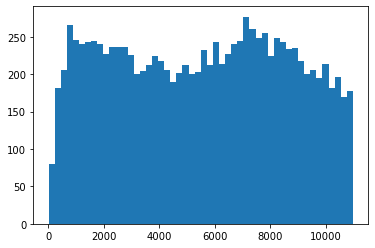

In [84]:
print(sub_esmb.mean())
dfsub.target = sub_esmb

display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [85]:
dfsub.to_csv(f'{p_esmb}/submission_{PRFX_ESMB}.csv', index=False)